# Plot all results 

In [128]:
import matplotlib.pyplot as plt
import pickle
from glob import glob
import numpy as np

from sklearn.metrics import r2_score

plt.style.use(["science", "nature", "std-colors"])

colors = ["#0C5DA5", "#00B945", "#FF9500", "#FF2C00", "#845B97", "#474747", "#9e9e9e"]

LOG_CONVERSION = np.log(10)

This assumes that you have for folders named `lab_z_av`, `lab_pdi`, 'merged_z_av', `merged_pdi` with contents created using the commant `sonipredict.tune_pred`.

In [129]:
z_av_lab = glob("lab_z_av/*.pkl")
pdi_lab = glob("lab_pdi/*.pkl")


z_av_merged = glob("merged_z_av/*.pkl")
pdi_merged = glob("merged_pdi/*.pkl")

In [130]:
def filter_out_res(files):
    z_av_lab_res = []

    for f in files:
        NOT_IN_NAME = True
        for name in ["shap", "params", "model"]:
            if name in f:
                NOT_IN_NAME = False
        if NOT_IN_NAME:
            z_av_lab_res.append(f)

    return z_av_lab_res

In [131]:
def read_pkl(f):
    with open(f, "rb") as handle:
        return pickle.load(handle)

In [132]:
def compute_metrics(results):
    r2_scores = []

    for result in results:
        true = result["test"]["labels"]["mean"]
        pred = result["test"]["prediction"]["mean"]
        r2_scores.append(r2_score(true,pred))

    return r2_scores, np.argmax(r2_scores)

In [133]:
def load_results(files):
    all_results = []

    for f in filter_out_res(files):
        all_results.append(read_pkl(f))
    
    return all_results

In [134]:
lab_z_av_results = load_results(z_av_lab)
lab_pdi_results = load_results(pdi_lab)

merged_z_av_results = load_results(z_av_merged)
merged_pdi_results = load_results(pdi_merged)

In [135]:
r2_scores_lab_z_av, best_lab_z_av = compute_metrics(lab_z_av_results)
r2_scores_lab_pdi, best_lab_pdi = compute_metrics(lab_pdi_results)

r2_scores_merged_z_av, best_merged_z_av = compute_metrics(merged_z_av_results)
r2_scores_merged_pdi, best_merged_pdi = compute_metrics(merged_pdi_results)

In [136]:
def return_parity_plot(all_results, max_val=3.2, min_val=1.8, best_index=36, log_conversion=LOG_CONVERSION, c=colors[0]):
    fig, ax = plt.subplots(1, 2, sharex='all', sharey='all')
    
    for i, res in enumerate(all_results):
        if i == best_index:
            continue 
        else:
            ax[0].errorbar(
                res["train"]["labels"]["mean"] / log_conversion,
                res["train"]["prediction"]["mean"] / log_conversion,
                yerr=res["train"]["prediction"]["std"] / log_conversion,
                xerr=res["train"]["labels"]["std"] / log_conversion,
                color='grey',
                alpha=0.2,
                ls="none",
                label="lab",
            )


            ax[1].errorbar(
                res["test"]["labels"]["mean"] / log_conversion,
                res["test"]["prediction"]["mean"] / log_conversion,
                yerr=res["test"]["prediction"]["std"] / log_conversion,
                xerr=res["test"]["labels"]["std"] / log_conversion,
                color='grey',
                alpha=0.2,
                ls="none",
                label="lab",
            )

    # plot best on top
    res = all_results[best_index]
    ax[0].errorbar(
            res["train"]["labels"]["mean"] / log_conversion,
            res["train"]["prediction"]["mean"] / log_conversion,
            yerr=res["train"]["prediction"]["std"] / log_conversion,
            xerr=res["train"]["labels"]["std"] / log_conversion,
            color=c,
            ls="none",
            label="lab",
        )


    ax[1].errorbar(
        res["test"]["labels"]["mean"] / log_conversion,
        res["test"]["prediction"]["mean"] / log_conversion,
        yerr=res["test"]["prediction"]["std"] / log_conversion,
        xerr=res["test"]["labels"]["std"] / log_conversion,
        color=c,
        ls="none",
        label="lab",
    )

    ax[0].set_title("train")
    ax[1].set_title("test")

    ax[0].set_xlim(min_val, max_val)
    ax[0].set_ylim(min_val, max_val)

    for a in ax: 
        a.plot([min_val, max_val], [min_val, max_val], color="black", ls="--")

    fig.text(0.5, 0.01, "measured", ha="center")
    ax[0].set_ylabel("predicted")

    fig.tight_layout()

    return fig, ax

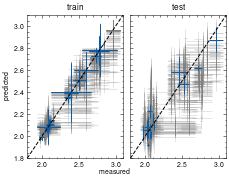

In [137]:
fig, ax = return_parity_plot(lab_z_av_results, max_val=3.1, best_index=best_lab_z_av)
fig.savefig('lab_z_av_parity.pdf')

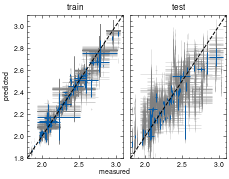

In [138]:
fig, ax = return_parity_plot(merged_z_av_results,  max_val=3.1, best_index=best_merged_z_av)
fig.savefig('merged_z_av_parity.pdf')

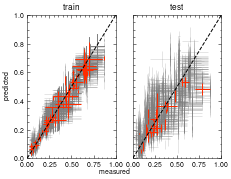

In [139]:
fig, ax = return_parity_plot(merged_pdi_results,  min_val=0, max_val=1, best_index=best_merged_pdi, log_conversion=1, c=colors[3])
fig.savefig('merged_pdi_parity.pdf')

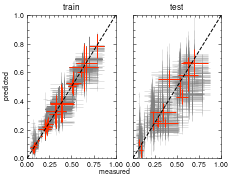

In [140]:
return_parity_plot(lab_pdi_results,  min_val=0, max_val=1, best_index=best_lab_pdi, log_conversion=1, c=colors[3])
fig.savefig('lab_pdi_parity.pdf')

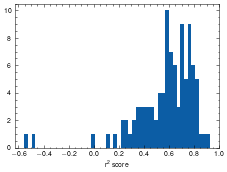

In [142]:
fig, ax = plt.subplots(1,1)

ax.hist(r2_scores_lab_z_av, bins=50, color=colors[0])
ax.set_xlabel(r"r$^2$ score")
fig.tight_layout()
fig.savefig('lab_z_av_r2_hist.pdf')

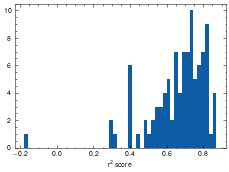

In [145]:
fig, ax = plt.subplots(1,1)

ax.hist(r2_scores_lab_pdi, bins=50, color=colors[0])
ax.set_xlabel(r"r$^2$ score")
fig.tight_layout()
fig.savefig('lab_z_pdi_r2_hist.pdf')

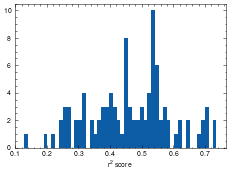

In [146]:
fig, ax = plt.subplots(1,1)

ax.hist(r2_scores_merged_pdi, bins=50, color=colors[0])
ax.set_xlabel(r"r$^2$ score")
fig.tight_layout()
fig.savefig('merged_pdi_r2_hist.pdf')

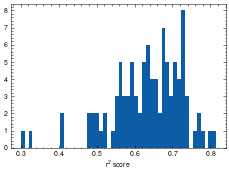

In [147]:
fig, ax = plt.subplots(1,1)

ax.hist(r2_scores_merged_z_av, bins=50, color=colors[0])
ax.set_xlabel(r"r$^2$ score")
fig.tight_layout()
fig.savefig('merged_z_av_r2_hist.pdf')

In [148]:
print("lab_z_av:", best_lab_z_av)
print("lab_pdi:", best_lab_pdi)
print("merged_z_av:", best_merged_z_av)
print("merged_pdi:", best_merged_pdi)

lab_z_av: 99
lab_pdi: 95
merged_z_av: 14
merged_pdi: 99
